In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
from app.algorithms import compute_urm, compute_utm, compute_em, compute_stm


In [4]:
import tqdm
import random
import matplotlib.pyplot as plt

In [5]:
# CONSTANTS
LIMIT_STOCKS = 70  # number of stocks (out of 500)
WINDOW_SIZE = 50  # for computing volatility
LIMIT_NUM_OF_RECORDS = None  # limit the number of days, set to None in order to disable
FLIP_X = False  # whether to reverse the order of X
TRIAL = 10  # number of evaluations for each config (page 10 on paper, denoted by j)
TEST_SIZE = 10  # test size to evaluate each time
TEST_START_POINT = 630 # where do we start to evaluate

### data

In [6]:
df = pd.read_csv('all_data.csv')

In [7]:
df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65.777748,51.647556,104.796822,41.310070,82.956924,88.406036,192.490005,55.480598,145.921112,177.699997,...,43.540058,64.657593,69.928825,65.382240,65.220093,76.699928,120.948624,103.709999,46.021923,70.275375
2,67.451401,51.014027,105.745117,41.302879,84.255081,88.735046,195.820007,55.603271,146.594574,181.039993,...,43.248634,65.953041,71.302231,65.158272,66.015335,76.634125,121.787064,105.769997,45.967468,70.598511
3,66.945419,51.335667,109.646957,41.494736,83.774597,88.537621,199.250000,55.508900,148.330338,183.220001,...,42.911682,67.143723,71.400948,65.148529,66.456100,77.414291,121.611588,107.860001,46.158089,71.019547
4,68.015762,51.316177,110.812576,41.967163,85.232941,89.609322,202.320007,55.669323,149.553955,185.339996,...,42.611153,70.629974,71.343353,66.063927,66.331535,77.865448,122.820503,109.540001,46.176235,71.832275


In [8]:
df.shape

(784, 505)

In [9]:
def pre_process(df, limit_stocks=70):
    # first row has nans
    _df = df.iloc[1:]
    # drop any stocks which has nan values
    _df = _df.dropna(axis=1)
    
    if limit_stocks is not None:
        _df = _df.iloc[:,:limit_stocks].reset_index(drop=True)
    return _df

In [10]:
df = pre_process(df, limit_stocks=LIMIT_STOCKS)

In [11]:
df.shape

(783, 70)

In [12]:
def log_returns(df):
    _df = pd.DataFrame()
    cols = [x for x in df.columns]
    for col in cols:
        _df[col] = np.log(df[col] / df[col].shift(1))
        
    return _df.iloc[1:]

In [13]:
ldf = log_returns(df)

In [14]:
ldf.values

array([[ 0.02512574, -0.01234225,  0.0090082 , ...,  0.00081521,
        -0.00088144,  0.01101501],
       [-0.0075297 ,  0.00628514,  0.03623408, ...,  0.01287606,
         0.00790516, -0.00943402],
       [ 0.01586183, -0.00037972,  0.01057455, ...,  0.00226464,
         0.01217412,  0.02534741],
       ...,
       [-0.00510508, -0.01253148, -0.01337622, ...,  0.00489637,
        -0.00454802,  0.01647302],
       [ 0.00136388,  0.01811983,  0.00617153, ...,  0.00810769,
         0.00487681,  0.00140744],
       [ 0.00932682, -0.0238106 , -0.00095197, ...,  0.00971982,
         0.00714022,  0.01118897]])

In [15]:
def clip_log_returns(df):
    ub = np.quantile(df.values, .95)
    lb = np.quantile(df.values, .05)
    _df = df.apply(lambda x: np.clip(x, lb, ub))
    return _df

In [16]:
cdf = clip_log_returns(ldf)

In [17]:
def normalize_with_vol(df, window_size=50):
    _sqr = lambda x: np.sqrt(np.sum([_x**2 for _x in x])/window_size)
    vol = df.rolling(window_size).apply(lambda x: _sqr(x))
    
    _df = df / vol
    return _df.iloc[window_size:].reset_index(drop=True)

In [18]:
ndf = normalize_with_vol(cdf, window_size=WINDOW_SIZE)

/home/deebee/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
ndf.shape

(732, 70)

In [20]:
ndf.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMY,BR,BSX
0,-0.766402,-0.987360,-0.867723,-0.599383,-0.387587,-1.185224,0.525817,-0.425954,-0.753034,-0.402830,...,0.549960,-0.390211,-1.240757,0.641750,0.397808,-0.551471,-1.205057,-0.050966,-0.165772,-0.995857
1,0.263691,-0.115557,0.018543,0.082656,-1.835075,-0.723960,-0.252939,-0.339580,0.939386,0.132317,...,0.215910,-0.209214,-0.023094,-0.038392,-1.149564,-0.112696,0.053630,-0.390936,-0.590016,-0.408287
2,-0.287457,0.241225,-0.218861,-0.249678,-0.592518,-0.450861,-0.303950,0.736509,-0.989982,1.955685,...,0.202364,-1.412161,0.172944,-0.556142,1.485629,0.623517,-0.662845,0.359780,0.138896,0.222892
3,-0.576603,-0.819339,-0.355844,-1.076303,-0.827414,-1.885161,-1.040152,-1.137088,-0.137160,-0.970126,...,-2.067799,-0.187412,-0.760588,-0.853396,-0.543835,-1.063575,-0.665996,-0.543942,-0.313498,-0.767628
4,0.540374,0.731906,-0.763378,-0.023921,0.307042,-1.823767,1.220374,0.483013,1.127411,1.928932,...,0.301657,0.096863,0.104593,-0.272526,-1.129765,0.401829,-0.615361,0.369458,1.663765,0.130444


In [21]:
def gen_dataset(df, limit=None, flip=True):
    X = df.values
    if limit is not None:
        X = X[:limit,:]
    _X = X.T
    if flip:
        _X = np.flip(_X, axis=1)
    
    return _X

In [22]:
X = gen_dataset(ndf, limit=LIMIT_NUM_OF_RECORDS, flip=FLIP_X)

In [23]:
X.shape

(70, 732)

In [24]:
def split_train_test(X, N, t, test_size=10):
    #print("Split, X shape: {}, N: {}, t: {}, test_size: {}".format(X.shape, N, t, test_size))
    test = X[:,t:t+test_size]
    train = X[:,t-N:t]
    
    return train, test

In [25]:
def log_likelihood(Sigma, Sigma_SAM, N):
    if (np.isnan(Sigma)).any():
        return np.nan
    M = Sigma.shape[0]
    a = M * np.log(2*np.pi)
    b = np.log(np.linalg.det(Sigma))
    c = np.trace(np.linalg.lstsq(Sigma, Sigma_SAM, rcond=None)[0])
    ret_value = -(N/2) * (a+b+c)
    return ret_value

In [26]:
def gen_args(lambda_factor=1):
    # GENERATE TRAIN ARGS - RANDOM K AND LAMBDA
    
    M = ndf.shape[1] # data dimension
    scan_N = (np.array([0.25, 0.5, 1, 2]) * M).astype(np.int) # the sizes of datasets
    default_K = np.random.randint(low=1, high=M*2, size=4) # the corresponding K to use
    default_lambda = lambda_factor * np.random.rand(4) * M # the corresponding lambda to use
    default_gamma = np.array([8, 6, 4, 2]) * M  # NOT USED
    
    print("K {}".format(default_K))
    print("LAMBDA: {}".format(default_lambda))
    
    return M, scan_N, default_K, default_lambda, default_gamma

In [27]:
#M, scan_N, default_K, default_lambda, default_gamma = gen_args()

In [28]:
# arguments required for training
M = ndf.shape[1] # data dimension
scan_N = (np.array([0.25, 0.5, 1, 2]) * M).astype(np.int) # the sizes of datasets
default_K = np.array([5, 9, 15, 20]) # the corresponding K to use
default_lambda = np.array([2.6, 1.4, 1, .9]) * M # the corresponding lambda to use
default_gamma = np.array([8, 6, 4, 2]) * M  # NOT USED

## UTM / URM

In [29]:
## log likelihood record keeper
UTM_llh = np.zeros((TRIAL, len(scan_N)))
URM_llh = np.zeros((TRIAL, len(scan_N)))

# begin of simulation
print(default_K)
print(default_lambda)
for index_N, (N, train_K, train_lambda, train_gamma) in enumerate(zip(scan_N, default_K, default_lambda, default_gamma)):
    for trial in tqdm.tqdm(range(TRIAL)):

        # compute sample covaraince matrix
        train, test = split_train_test(X, N=N,t=TEST_START_POINT+TEST_SIZE*trial,test_size=TEST_SIZE)


        Sigma_SAM = np.zeros((M,M))
        for n in range(N):
            Sigma_SAM += np.outer(train[:,n], train[:,n])
        Sigma_SAM /= N

        # test cov matrix
        Sigma_SAM_test = np.zeros((M,M))
        _N_TEST = test.shape[1]
        for n in range(_N_TEST):
            Sigma_SAM_test += np.outer(test[:,n], test[:,n])
        Sigma_SAM_test /= _N_TEST

        # URM
        Sigma_URM = compute_urm(Sigma_SAM, train_K)
        URM_llh[trial, index_N] = log_likelihood(Sigma_URM, Sigma_SAM_test, N)

        # UTM
        Sigma_UTM = compute_utm(Sigma_SAM, train_lambda, N)
        UTM_llh[trial, index_N] = log_likelihood(Sigma_UTM, Sigma_SAM_test, N)

 40%|████      | 4/10 [00:00<00:00, 36.55it/s]

[ 5  9 15 20]
[182.  98.  70.  63.]


100%|██████████| 10/10 [00:00<00:00, 34.89it/s]


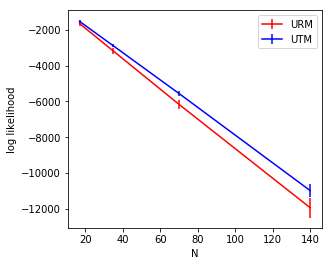

In [30]:
# plot the results
log_scan_N = scan_N
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.errorbar(log_scan_N, URM_llh.mean(axis=0), URM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='URM')
plt.errorbar(log_scan_N, UTM_llh.mean(axis=0), UTM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='UTM')
    
plt.xlabel('N');
plt.ylabel('log likelihood');
plt.legend()

In [31]:
URM_llh.mean(axis=0)

array([ -1648.78744543,  -3184.98779006,  -6162.58475152, -11946.94652957])

In [32]:
UTM_llh.mean(axis=0)

array([ -1526.02702434,  -2893.27449881,  -5556.84328749, -10987.56114523])

## STM / EM

In [33]:
## log likelihood record keeper
STM_llh = np.zeros((TRIAL, len(scan_N)))
EM_llh = np.zeros((TRIAL, len(scan_N)))

for index_N, (N, train_K, train_lambda, train_gamma) in enumerate(zip(scan_N, default_K, default_lambda, default_gamma)):
    for trial in tqdm.tqdm(range(TRIAL)):
        # compute sample covaraince matrix
        train, test = split_train_test(X, N=N,t=TEST_START_POINT+TEST_SIZE*trial,test_size=TEST_SIZE)

        # compute sample covaraince matrix
        Sigma_SAM = np.zeros((M,M))
        for n in range(N):
            Sigma_SAM += np.outer(train[:,n], train[:,n])
        Sigma_SAM /= N

        # test cov matrix
        Sigma_SAM_test = np.zeros((M,M))
        _N_TEST = test.shape[1]
        for n in range(_N_TEST):
            Sigma_SAM_test += np.outer(test[:,n], test[:,n])
        Sigma_SAM_test /= _N_TEST

        # STM
        Sigma_STM = compute_stm(Sigma_SAM, train_lambda, N)
        STM_llh[trial, index_N] = log_likelihood(Sigma_STM, Sigma_SAM_test, N)

        # EM
        Sigma_EM = compute_em(Sigma_SAM, train_K)
        EM_llh[trial, index_N] = log_likelihood(Sigma_EM, Sigma_SAM_test, N)

  0%|          | 0/10 [00:00<?, ?it/s]/home/deebee/personal-work/courses/spring21/ml-finance/presentation/app/algorithms.py:92: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  dt, _, _, _ = np.linalg.lstsq(-hessian, gradient)
100%|██████████| 10/10 [00:14<00:00,  1.38s/it]


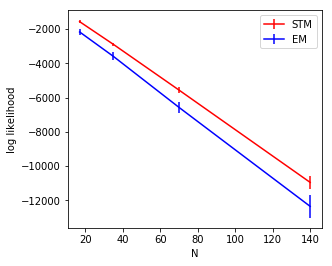

In [34]:
# plot the results
log_scan_N = scan_N
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.errorbar(log_scan_N, STM_llh.mean(axis=0), STM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='STM')
plt.errorbar(log_scan_N, EM_llh.mean(axis=0), EM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='EM')
    
plt.xlabel('N');
plt.ylabel('log likelihood');
plt.legend()